In [17]:
import numpy as np
import tensorflow as tf
import cPickle as pickle
import matplotlib.pyplot as plt
from sklearn import metrics

In [18]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [19]:
def confusion_matrix(predictions, labels):
    pred = np.argmax(predictions, 1)
    actual = np.argmax(labels, 1)
    
    print "Actuals ", np.bincount(actual)
    print "Predictions ", np.bincount(pred)
    
    print "Accuracy ", 100.0 * np.sum(pred == actual) / pred.shape[0]
    print "Two class confusion matrix"
    p = (pred != 0)
    a = (actual != 0)
    print metrics.confusion_matrix(p, a)

In [20]:
pickle_file = 'badged_images.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']

  custom_test_dataset = save['custom_test_dataset']
  custom_test_labels = save['custom_test_labels']
  del save  # hint to help gc free up memory

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
print('Custom Test set', custom_test_dataset.shape, custom_test_labels.shape)

('Training set', (2000, 256, 256, 3), (2000,))
('Validation set', (250, 256, 256, 3), (250,))
('Test set', (250, 256, 256, 3), (250,))
('Custom Test set', (57, 256, 256, 3), (57,))


In [21]:
num_labels = np.unique(train_labels).shape[0]
image_height = train_dataset.shape[1]
image_width = train_dataset.shape[2]
num_channels = 1

if len(train_dataset.shape) > 3:
    num_channels = train_dataset.shape[3]

def reformat(dataset):
  return dataset.reshape(
    (-1, image_height, image_width, num_channels)).astype(np.float32)

def one_hot_encoding(labels):
  return (np.arange(num_labels) == labels[:,None]).astype(np.float32)

In [22]:
print num_labels, image_height, image_width

train_dataset = reformat(train_dataset)
valid_dataset = reformat(valid_dataset)
test_dataset = reformat(test_dataset)
custom_test_dataset = reformat(custom_test_dataset)

train_labels = one_hot_encoding(train_labels)
valid_labels = one_hot_encoding(valid_labels)
test_labels = one_hot_encoding(test_labels)
custom_test_labels = one_hot_encoding(custom_test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
print('Custom Test set', custom_test_dataset.shape, custom_test_labels.shape)

2 256 256
('Training set', (2000, 256, 256, 3), (2000, 2))
('Validation set', (250, 256, 256, 3), (250, 2))
('Test set', (250, 256, 256, 3), (250, 2))
('Custom Test set', (57, 256, 256, 3), (57, 2))


In [23]:
print "Validation baseline accuracy"
confusion_matrix(one_hot_encoding(np.zeros(valid_labels.shape[0])), valid_labels)

print "Test baseline accuracy"
confusion_matrix(one_hot_encoding(np.zeros(test_labels.shape[0])), test_labels)

Validation baseline accuracy
Actuals  [150 100]
Predictions  [250]
Accuracy  60.0
Two class confusion matrix
[[150 100]
 [  0   0]]
Test baseline accuracy
Actuals  [156  94]
Predictions  [250]
Accuracy  62.4
Two class confusion matrix
[[156  94]
 [  0   0]]


In [24]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [40]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64


graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_height, image_width, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  tf_custom_test_dataset = tf.constant(custom_test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))

  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))

  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_height // 4 * image_width // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))

  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    h_conv1 = tf.nn.relu(conv2d(data, layer1_weights) + layer1_biases)
    h_pool1 = max_pool_2x2(h_conv1) 
    
    h_conv2 = tf.nn.relu(conv2d(h_pool1, layer2_weights) + layer2_biases)
    h_pool2 = max_pool_2x2(h_conv2)

    shape = h_pool2.get_shape().as_list()
    reshape = tf.reshape(h_pool2, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  # optimizer = tf.train.GradientDescentOptimizer(0.00005).minimize(loss)

  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
         0.0001, global_step, 500, 0.96, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(
        loss, global_step=global_step)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))
  custom_test_prediction = tf.nn.softmax(model(tf_custom_test_dataset))

In [41]:
%%time
num_steps = 2001

minibatch_loss = np.nan * np.ones(num_steps)
validation_loss = np.nan * np.ones(num_steps)

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    minibatch_loss[step] = l
    validation_loss[step] = l
    
    if (step % 50 == 0):
      print ('Learning Rate %f' % learning_rate.eval())

      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
    
      valid_preds = valid_prediction.eval()
      print('Validation accuracy: %.1f%%' % accuracy(valid_preds, valid_labels))

  test_preds = test_prediction.eval()
  print('Test accuracy: %.1f%%' % accuracy(test_preds, test_labels))
  confusion_matrix(test_preds, test_labels)

  custom_test_preds = custom_test_prediction.eval()
  print('Custom Test accuracy: %.1f%%' % accuracy(custom_test_preds, custom_test_labels))
  confusion_matrix(custom_test_preds, custom_test_labels)

Initialized
Learning Rate 0.000100
Minibatch loss at step 0: 1086.012939
Minibatch accuracy: 40.6%
Validation accuracy: 40.0%
Learning Rate 0.000100
Minibatch loss at step 50: 179.691589
Minibatch accuracy: 71.9%
Validation accuracy: 60.0%
Learning Rate 0.000100
Minibatch loss at step 100: 4.826299
Minibatch accuracy: 59.4%
Validation accuracy: 40.0%
Learning Rate 0.000100
Minibatch loss at step 150: 3.218193
Minibatch accuracy: 34.4%
Validation accuracy: 60.0%
Learning Rate 0.000100
Minibatch loss at step 200: 3.008315
Minibatch accuracy: 34.4%
Validation accuracy: 40.0%
Learning Rate 0.000100
Minibatch loss at step 250: 1.381816
Minibatch accuracy: 34.4%
Validation accuracy: 60.0%
Learning Rate 0.000100
Minibatch loss at step 300: 1.723610
Minibatch accuracy: 56.2%
Validation accuracy: 40.0%
Learning Rate 0.000100
Minibatch loss at step 350: 7.147064
Minibatch accuracy: 59.4%
Validation accuracy: 60.0%
Learning Rate 0.000100
Minibatch loss at step 400: 6.160699
Minibatch accuracy: 53

0.5


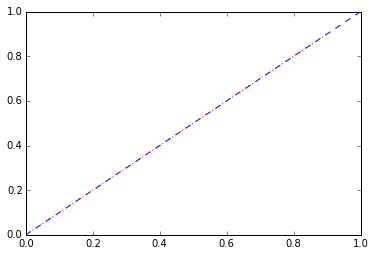

In [42]:
%matplotlib inline

y = custom_test_labels[:,0]
pred = custom_test_preds[:, 0]
fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)

plt.plot(fpr, tpr, 'b--', np.arange(0, 1, 0.1), np.arange(0, 1, 0.1), 'r:')
print metrics.auc(fpr, tpr)

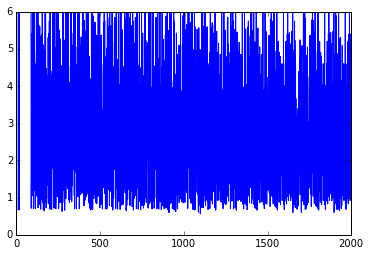

In [43]:
plt.axis((0, num_steps, 0, 6))
plt.plot(minibatch_loss)

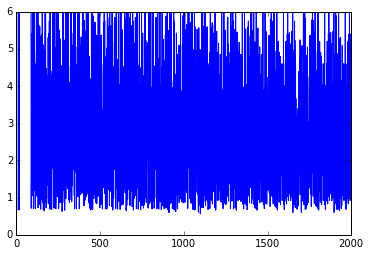

In [44]:
plt.axis((0, num_steps, 0, 6))
plt.plot(validation_loss)